<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/classica/clusterizacaoNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Pool, Process
import multiprocessing as mp
from sklearn.pipeline import make_pipeline
from google.colab import files, drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [2]:
#!rm news.*
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
#!unzip news.zip
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/nlp_tcc/
!ls -lh 


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/nlp_tcc
total 1.2G
drwx------ 3 root root 4.0K Jul 31 20:13 amostra_news_integrada
-rw------- 1 root root 481M Jul 24 17:03 articles.csv
drwx------ 2 root root 4.0K Jul 31 17:49 bertimbau_base_results
drwx------ 2 root root 4.0K Jul 31 19:09 bertimbau_test
-rw------- 1 root root  93M Jul 24 15:58 news.csv
-rw------- 1 root root 521M Jul 25 22:30 news_integradas.csv
-rw------- 1 root root  93M Jul 24 15:42 noticia_tratada.csv


In [3]:
mp.cpu_count()

2

# Funções para processamento de Linguagem Natural

In [10]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, n_grams=(1,1), excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW, ngram_range=n_grams) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf(V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X)
    X_pca =  UT.fit_transform(X)
      
    return [UT,X_pca]

def padronizaValores(X):
  X_norm = StandardScaler(with_mean=False).fit_transform(X)
  return X_norm

def retornaPalavras(listaTexto:list):
  words=""
  for i in listaTexto: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
  words += " ".join(separate)+" "
  return words
def montaWordCloud(words, n_palavras:int, sw=None):
  wc = WordCloud(width = 400, height = 200, 
                background_color ='black', max_words=n_palavras,
                min_font_size = 10, stopwords = sw).generate(words)
  return wc

def imprimiWordCloud(listaTexto:list, n_palavras:int, cluster:str=None, sw=None):
  words = retornaPalavras(listaTexto)
  wc = montaWordCloud(words, n_palavras, sw)
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  if not cluster == None:
    plt.title('PALAVRAS PARA O CLUSTER ' + cluster)
  plt.show()

def preProcessaTextos(dfDados):
  download_pt_stopWords()
  dfDados['text'] = dfDados['text'].astype('unicode')
  dfDados['text'] = dfDados['text'].map(removeCaracteresNaoDesejados)
  dfDados['text'] = dfDados['text'].map(removeStopWords)
  dfDados['text'] = dfDados['text'].map(aplicaStemming)
  return dfDados
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeCaracteresNaoDesejados(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: removeStopWords(x['text']),axis=1)
  #dfDados['text'] = dfDados.loc[:,['text']].apply(lambda x: aplicaStemming(x['text']),axis=1)

def PreProcessamentoParalelo(df, n_jobs):
  df_split = np.array_split(df,n_jobs)
  pool = Pool(n_jobs)
  resultado = pool.map(preProcessaTextos, df_split)
  df = pd.concat(resultado, sort=False)
  return df

def processaVetorizacao(dfDados,min_fr=0.01, max_fr=0.7, ngrams=(1,1)):
  X = dfDados['text'].values
  vetores = retornaVetorizacao(X,min_fr,max_fr,ngrams)
  V = vetores[0]
  return V
  

# Prepara dataset para clusterizacao

In [3]:
#dfDados = pd.read_csv('news_integradas.csv')
dfDados = pd.read_csv('./amostra_news_integrada/amostra_4/amostra.csv')
print(dfDados.shape)

(22213, 2)


In [ ]:
#dfDados = dfDados.sample(frac=0.10)
#print(dfDados.shape)

(7129, 2)


In [6]:
dfDados.columns

Index(['text', 'category_nro'], dtype='object')

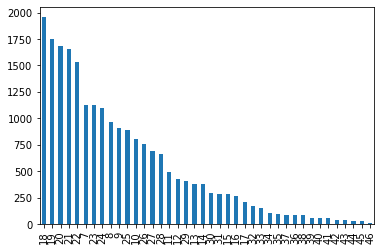

In [7]:
df = dfDados['category_nro'].value_counts()
df =df.head(40)
df.plot.bar()


In [11]:
#abrir arquivo news.csv
%%time

#dfDados = dfDados.sample(frac=0.2)

dfPreProc = PreProcessamentoParalelo(dfDados,mp.cpu_count())
#dfPreProc = preProcessaTextos(dfDados.copy())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 2.07 s, sys: 513 ms, total: 2.58 s
Wall time: 6min 12s


In [10]:
print(dfPreProc.shape)
dfPreProc.head()

(22213, 2)


,text,category_nro
0,avarent malhumor lob wall street hollywood abord sob divers ângul pod corrup dinh relat tel grand confi dinh torn pesso má psicólog soc paul piff pass algum tard cruz faix pedestr beiram lo angel mei skat passe cão graç grand númer endinheir reg falt carr lux híbr espor rua piff ali ilustr exper provoc qu sab motor ric par menos pedestr pobr motor lei obrig par alguém quis atravess rua enquant lexu pass frent deix cruz rua piff explic pesquis descobr nenhum motor carr barat desrespeit lei enquant quas motor carr car desrespeit diz piff pergunt divers pesso difer cl soc comport difer cen pass percepç públic tend noç pobr probabil mai agir form ileg est sob press financ sob condiç difícel pesquis piff sug contr ter dinh faz preocup menos outr sint direit coloc inter própri prim lug após quas déc pesquis ness áre piff cheg polêm conclus prosper vez transform benfeitor pod ser alg ruim bússol moral dinh torn afin própri inter própri bemest diz cert form isol outr pesso psicologic mater prioriz necess obje fic menos conect pesso redor der canet ped desenh círcul represent si quant prósper mai círcul relaç tamanh círcul desenh pesso pobr test dit laboratóri psicológ piff conduz estud sug pesso dinh têm propens trapac jog dad com doc guard crianç menos vontad ced temp ajud demal us ferrament conhec psicólog test dit piff reun grup pesso deu us algum diss pod compartilh tud part nad dinh particip hav receb quant econom racion dir pobr tend guard dinh si mesm ric tend do descobr opost diss quant ric levandos cont divers outr vari menos gener dá porç significativ men outr pesso pobr bast gener outr estud manipul jog banc imobili privilegi jog dandolh dinh inici após dezen jog notous vitór traz ton pi lad dess jog mod prepot uso espaç com salg pot comunit sent prósper conclu piff precis menos outr pesso mund real pesso têm menos dinh cont relaç soc relaç acab send prior ric contr pod pag própr paz tranquil espaç além soluç maior problem nad cart chei anim ânim dur cris tend isol pesso experi demal question descobert piff cert têm encant traz confort pens don vantag financ menos pag preç tod convenc psicolog disciplin carreg dificuldad estud sempr traz fat confund conclus pesso atravess rua faz mod confi di carr barat motor real ric peg bmw emprest tio dad pesquis populac difícel ser decifr difícil separ caus efeit particip pesquis laboratóri dão respost pod ter relaç vid real estud difer métod cheg conclus semelh result começ ser vist signific desd piff public prim lev descobert outr cient redor mund têm tent replicál algum result confirm pesquis piff outr traz conclus opost estud holand feit milion identific gener méd trat do guard si pequen quant dinh anális dad populac feit acadêm europ encontr elo prosper falt generos máx encontr opost indivídu prósper tend oferec temp dinh demal ess dinh estud kathleen voh univers minnesot pod ajud explic conclus piff pesquis derrub quer pacot lápis sab pesso ajud pegál chã prim porém prepar metad particip estud alimentando fras relacion dinh decifr not dinh cont particip prepar costum ser menos predispost ajud peg lápis outr estud mostr menos gener convid do dinh caridad contr mostr pesquis piff evid obt voh parec ter pouc relaç fat particip ser ric pobr result replic país parec alg ide dinh form represent cabeç pesso provoc reaç parec pouc relaç sens est ric pobr diz voh afirm bast pens dinh evoc mental autossufici reflet fat dinh carreg ess transaç estranh cálcul prior inter própri costum us dinh relaç pesso quer result dinh torn determin menos sens necess sent demal pesquis hong kong lev ide além profes zhansheng chen yuw jiang descobr particip pesquis condicion pens dinh tend aceit transgr moral col prov ment currícul di dilem étic dur jog envolv puniç particip barulh alt prepar pens dinh costum submet advers barulh alt temp ato pens dinh torn agress foc preç lucr cont bancár orç pod ser benéf ambi escritóri integr organiz qu funcion coop si mantenh honest suborn bônu diz j

In [12]:
dfPreProc.to_csv('./amostra_news_integrada/amostra_4/dfPreProc.csv')

In [13]:
V = processaVetorizacao(dfPreProc,min_fr=0.01, max_fr=0.7, ngrams=(1,2))
X_tfidf = retornaMatriztfIdf(V)

* https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2
* https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019
* https://medium.com/@gilneyjnr/qualidade-de-agrupamentos-ci%C3%AAncia-de-dados-4b1176bef5e5


In [14]:
X = np.ones((X_tfidf.shape))
X_tfidf.toarray(out=X)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03433457, 0.01992446,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03860407,
        0.        ]])

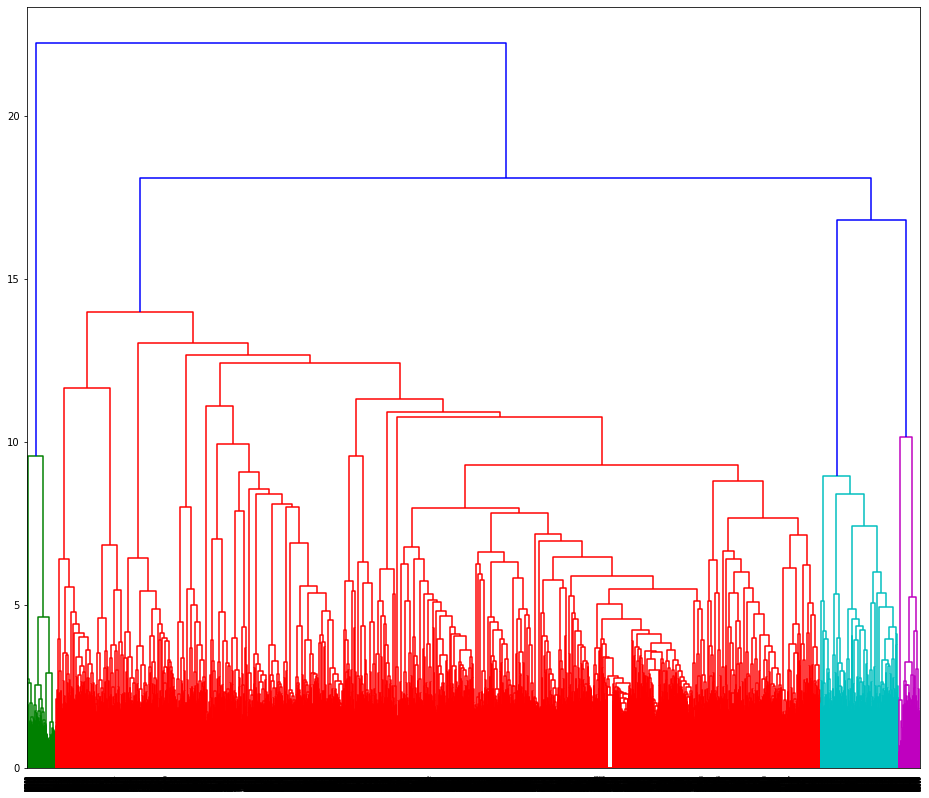

In [15]:
plt.figure(figsize=(16, 14))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.show()

In [29]:
def aplicaModelo(model, dfDados, X_tfidf):
  dfDadosPred = dfDados.copy()
  y_pred = model.fit_predict(X_tfidf.toarray())
  dfDadosPred['y_pred'] = y_pred
  print(dfDadosPred['y_pred'].value_counts())
  return dfDadosPred

In [20]:
model= AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)

Index(['text', 'category_nro', 'y_pred'], dtype='object')

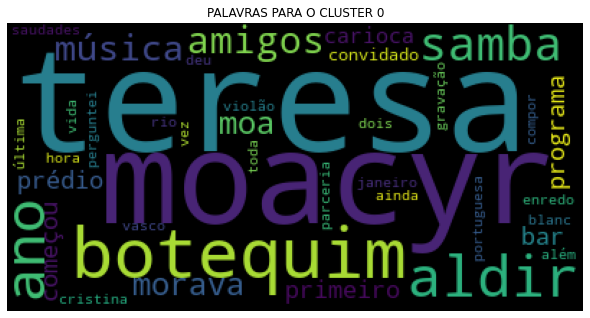

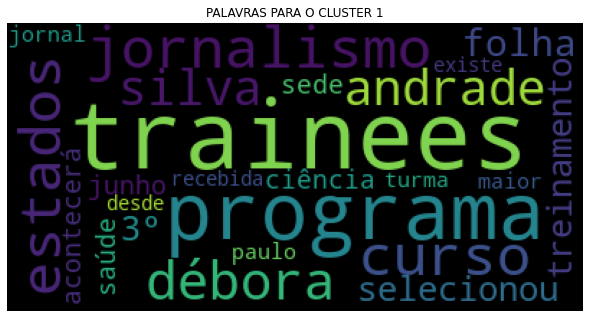

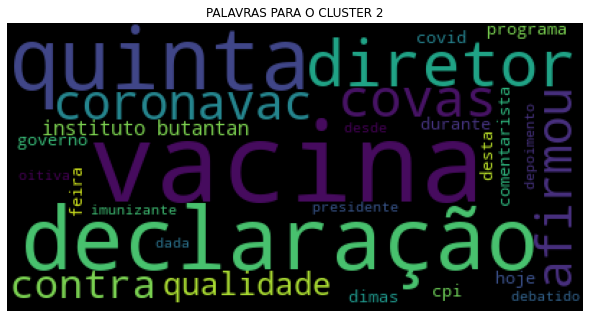

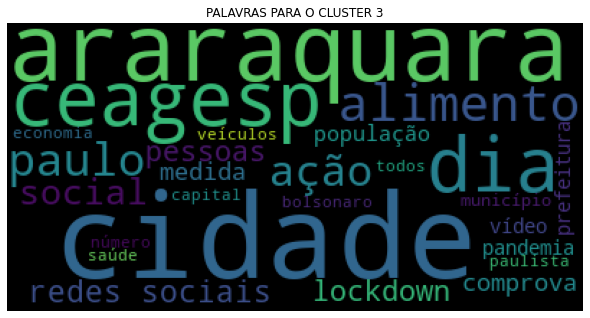

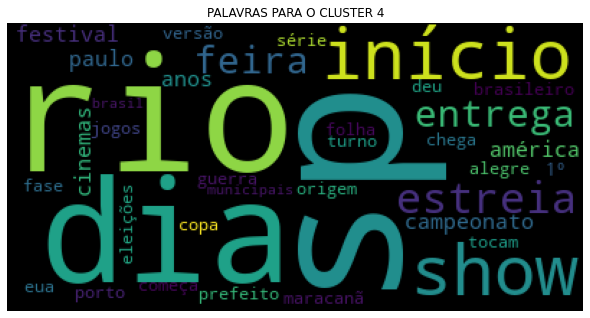

In [23]:
sw = nltk.corpus.stopwords.words('portuguese')
for y in np.sort(dfDadosPred['y_pred'].unique()):
  dftmp = dfDadosPred.loc[:,['text']][dfDadosPred['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),100,str(y),sw)

In [ ]:
model= AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)

In [ ]:
sw = nltk.corpus.stopwords.words('portuguese')
for y in np.sort(dfDadosPred['y_pred'].unique()):
  dftmp = dfDadosPred.loc[:,['text']][dfDadosPred['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),100,str(y),sw)

In [ ]:
model= AgglomerativeClustering(n_clusters=14, affinity='euclidean', linkage='ward')
dfDadosPred = aplicaModelo(model, dfDados, X_tfidf)

In [ ]:
sw = nltk.corpus.stopwords.words('portuguese')
for y in np.sort(dfDadosPred['y_pred'].unique()):
  dftmp = dfDadosPred.loc[:,['text']][dfDadosPred['y_pred']==y]
  imprimiWordCloud(dftmp['text'].tolist(),100,str(y),sw)